# CITS4403 Project draft code

### Config


In [167]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from IPython.display import clear_output
import random

# Agent parameters
NUM_AGENTS = 8

In [168]:
map = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
                [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
                [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

map_exits = np.where(map == 2)
map_exits: tuple[int, int] = list(zip(map_exits[1], map_exits[0]))


In [169]:
class Cell:
    def __init__(self):
        pass


In [170]:
from heapq import heappop, heappush

# A* - modified to compute costs from one location to all cells
def a_star_all(map, start: tuple[int, int]):
    pqueue = [] # Priority queue of (cost, (x, y)) tuples
    heappush(pqueue, (0, start))

    cost_map = {start: 0} # Stores the cost of getting to each point on the map

    while pqueue:
        # Node with next lowest cost
        current_cost, current = heappop(pqueue)

        # Check all possible moves (up, down, left, right)
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (current[0] + dx, current[1] + dy)

            if (neighbor[0] < 0 or neighbor[0] >= len(map[0])) or (neighbor[1] < 0 or neighbor[1] >= len(map)):
                continue
            if map[neighbor[1]][neighbor[0]] != 0: # walkable space
                continue

            current_neighbour_cost = current_cost + 1 # Cost is 1 for each step for now

            # If this is the best path to neighbor, record it
            if neighbor not in cost_map or current_neighbour_cost < cost_map[neighbor]:
                cost_map[neighbor] = current_neighbour_cost
                heappush(pqueue, (current_neighbour_cost, neighbor))

    return cost_map


In [171]:
class Person:
    def __init__(self, map):
        self.map = map
        self.x = 0
        self.y = 0
        self.safe = False
        self.dead = False

        self.init_random_position()

    def init_random_position(self):
        while True:
            x = random.randint(0, len(self.map[0]) - 1)
            y = random.randint(0, len(self.map) - 1)
            if self.map[y][x] == 0:
                self.x, self.y = x, y
                break

    def move_towards_exit(self, exit_costs):
        if self.safe or self.dead:
            return 0

        # Find the nearest exit using precomputed costs
        start = (self.x, self.y)
        nearest_exit = min(exit_costs.keys(), key=lambda exit: exit_costs[exit].get(start, float('inf')))

        # If the person is already at an exit, they are safe
        if start in map_exits:
            self.safe = True
            return 1

        # Use the precomputed cost map to find the next step towards the nearest exit
        current_cost = exit_costs[nearest_exit].get(start, float('inf'))
        best_move = start  # Stay in place if no valid move

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (self.x + dx, self.y + dy)
            if neighbor in exit_costs[nearest_exit] and exit_costs[nearest_exit][neighbor] < current_cost:
                best_move = neighbor
                current_cost = exit_costs[nearest_exit][neighbor]

        # Move the person to the best move
        self.x, self.y = best_move

In [172]:
class Simulation():
    def __init__(self, map, num_people):
        self.environment = np.array([[Cell() for _ in row] for row in map])

        self.people = [Person(map) for _ in range(num_people)]
        self.exit_costs = {exit: a_star_all(map, exit) for exit in map_exits} # Precompute A* for each exit

        # Metrics
        self.num_safe = 0
        self.num_dead = 0

    def step(self):
        # Move all people
        for person in self.people:
            res = person.move_towards_exit(self.exit_costs)
            if res == 1:
                self.num_safe += 1
                self.people.remove(person)

    def draw(self):
        height, width = map.shape

        # Draw map
        plt.axis([0, height, 0, width])
        plt.xticks([])
        plt.yticks([])

        wallsMap = np.where(map == 1, 1, 0)
        options={
            "cmap": 'Greens',
            "alpha": 0.7,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, height, 0, width]
        }

        plt.imshow(wallsMap, **options)

        # Draw people as green dots
        for person in self.people:
            plt.plot(person.x + 0.5, height - person.y - 0.5, '.', color='green')

        plt.show()

    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step

        try:
            for _ in range(frames-1):
                self.draw()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
        except KeyboardInterrupt:
            pass

        print(f"Number of people safe: {self.num_safe}")

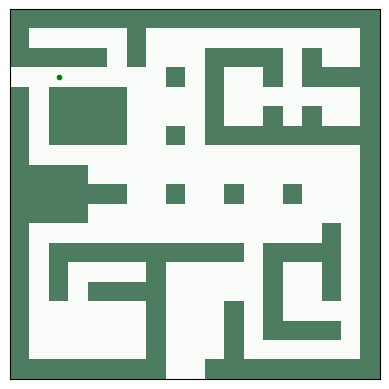

Number of people safe: 7


In [173]:
sim = Simulation(map, NUM_AGENTS)

sim.animate(30, 0.1)